In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(r"data_3dprinter.csv")
df['infill_pattern'] = df['infill_pattern'].map({'grid': 0, 'honeycomb': 1})
df['material'] = df['material'].map({'abs': 0, 'pla': 1})
df.rename(columns={"tension_strenght": "tensile_strength"}, inplace=True)

X = df[['layer_height', 'wall_thickness', 'infill_density', 'infill_pattern',
        'nozzle_temperature', 'bed_temperature', 'print_speed',
        'material', 'fan_speed']].values

y = df['tensile_strength'].values


R² Scores by Tree Depth (Train & Test):
Depth 1: Train R² = 0.3203, Test R² = 0.1206
Depth 2: Train R² = 0.5023, Test R² = 0.2773
Depth 3: Train R² = 0.6867, Test R² = 0.6115
Depth 4: Train R² = 0.8129, Test R² = 0.3838
Depth 5: Train R² = 0.8994, Test R² = -0.0629
Depth 6: Train R² = 0.9287, Test R² = -0.4516
Depth 7: Train R² = 0.9375, Test R² = -0.4516
Depth 8: Train R² = 0.9375, Test R² = -0.4516
Depth 9: Train R² = 0.9375, Test R² = -0.4516
Depth 10: Train R² = 0.9375, Test R² = -0.4516
Best Depth based on Test R²: 3 (Test R² = 0.6115)


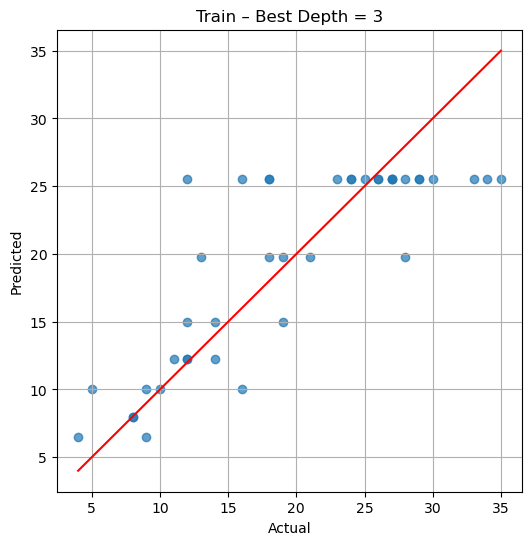

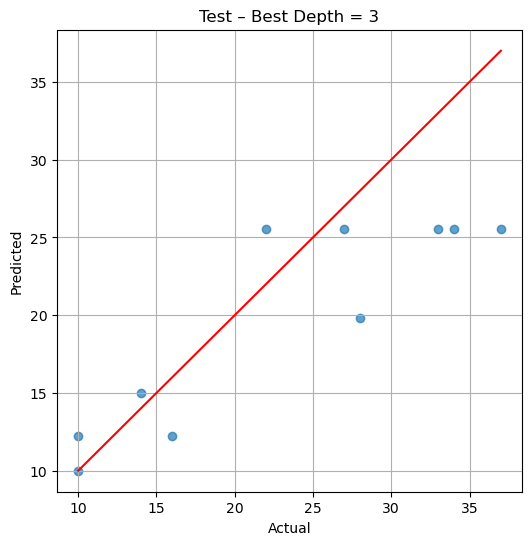

In [3]:

#Shuffle and split-used to increase accuracy of training and testing datasets 
np.random.seed(42) # ensuring randomness and reproducability
indices = np.random.permutation(len(X))
X, y = X[indices], y[indices]
#80% training set 20% testing set
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

class CustomDecisionTreeRegressor:
    def __init__(self, max_depth=3, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def mse(self, y):
        return np.var(y) * len(y)
#splitting each feature,checking for unique values for threshold
    def split_dataset(self, X, y, feature_index, threshold):
        left = X[:, feature_index] <= threshold
        right = X[:, feature_index] > threshold
        return X[left], X[right], y[left], y[right]
#Looping through all features and thresholds,simultaneously calculating and updating lowest MSE
    #We use MSE, since lowest MSE indicates lowest variance thereby indicating best split
    def best_split(self, X, y):
        best_feature, best_threshold, best_mse = None, None, float('inf')
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                X_left, X_right, y_left, y_right = self.split_dataset(X, y, feature, threshold)
                if len(y_left) < self.min_samples_split or len(y_right) < self.min_samples_split:
                    continue
                mse = self.mse(y_left) + self.mse(y_right)
                if mse < best_mse:
                    best_mse = mse
                    best_feature = feature
                    best_threshold = threshold
        return best_feature, best_threshold

    def build_tree(self, X, y, depth=0):
        if depth >= self.max_depth or len(y) < self.min_samples_split or len(set(y)) == 1:#Conditions for the tree to stop splitting and create a leaf 
            return np.mean(y) #returns mean of the current labels if no valid split is found
        feature, threshold = self.best_split(X, y) #Finds the best feature and threshold to split the current data
        if feature is None:
            return np.mean(y)#if no valid split is found a leaf node with mean value is created
        X_left, X_right, y_left, y_right = self.split_dataset(X, y, feature, threshold)
        return {
            "feature": feature,
            "threshold": threshold,
            "left": self.build_tree(X_left, y_left, depth + 1),
            "right": self.build_tree(X_right, y_right, depth + 1) }#Recursively building the tree, left and right indicate the result

    def fit(self, X, y):
        self.tree = self.build_tree(X, y) #calling fit functions so the tree can make predictions

    def predict_one(self, x, tree):
        if not isinstance(tree, dict):
            return tree
        if x[tree["feature"]] <= tree["threshold"]:
            return self.predict_one(x, tree["left"])
        else:
            return self.predict_one(x, tree["right"])

    def predict(self, X):
        return np.array([self.predict_one(x, self.tree) for x in X])

#Evaluation metrics
def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot

#Print R2 values and pick best depth based on test R²
print("R² Scores by Tree Depth (Train & Test):")
best_test_r2 = -float('inf')
best_depth = None
r2_train_values = []
r2_test_values = []

for depth in range(1, 11): #tests all depths from 1-10
    model = CustomDecisionTreeRegressor(max_depth=depth)#decision tree for the current depth
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)#prediction on training set
    y_test_pred = model.predict(X_test)#prediction on testing set
    #r^2 values calculated and stored for future graphs
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    r2_train_values.append(r2_train)
    r2_test_values.append(r2_test)

    print(f"Depth {depth}: Train R² = {r2_train:.4f}, Test R² = {r2_test:.4f}")
    #best r^2 and corresponding depth
    if r2_test > best_test_r2:
        best_test_r2 = r2_test
        best_depth = depth

print(f"Best Depth based on Test R²: {best_depth} (Test R² = {best_test_r2:.4f})")

#Final prediction & visualization
best_model = CustomDecisionTreeRegressor(max_depth=best_depth)
best_model.fit(X_train, y_train)
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)


#Plot Train
plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_train_pred, alpha=0.7)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r-')
plt.title(f"Train – Best Depth = {best_depth}")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)
plt.show()

#Plot Test
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r-')
plt.title(f"Test – Best Depth = {best_depth}")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)
plt.show()

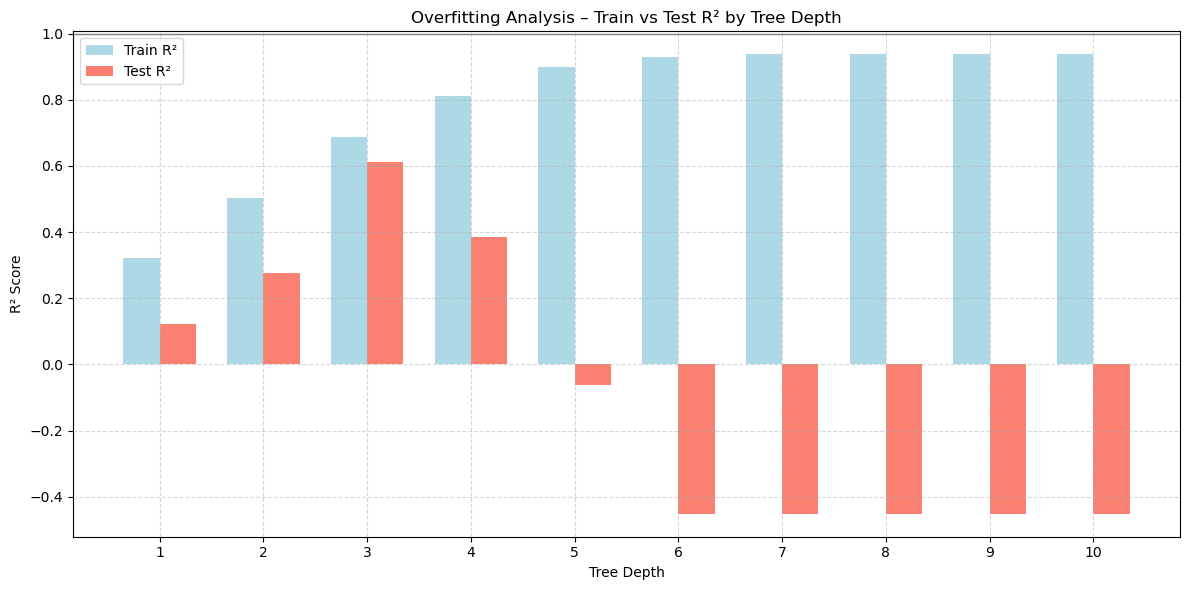

In [5]:

x = np.arange(1, 11)
bar_width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - bar_width/2, r2_train_values, width=bar_width, label='Train R²', color='lightblue')
plt.bar(x + bar_width/2, r2_test_values, width=bar_width, label='Test R²', color='salmon')
plt.xticks(x)
plt.xlabel("Tree Depth")
plt.ylabel("R² Score")
plt.title("Overfitting Analysis – Train vs Test R² by Tree Depth")
plt.axhline(1.0, color='gray', linestyle='-', linewidth=1)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


The bar graph is an analysis of overfitting/underfitting which was used by the decision tree to determine the best depth
* Depth 1-This is a classic case of underfitting, where the model lacks the capacity to learn from data.The model is too simple to capture meaningful relationships in the data. It fails to learn patterns in the training set.
* Depth 2-Train R² = 0.50, Test R² = 0.27
Although this model performs better than Depth 1, it still doesn't generalize well. The test R² is low, and both train/test errors indicate a lack of model complexity. It shows slight learning but remains underfitted.
* Depth 3- Train R² = 0.68, Test R² = 0.61
This depth provides the best balance. The gap between train and test performance is small, and both values are reasonably high. This is the optimal tree depth, giving the best generalization to unseen data. It avoids both overfitting and underfitting.
* Depth 4-Gap between testing and training data increasing-overfitting increasing,the model is starting to memorize training data patterns.
* Depth 5-Train R² = 0.89, Test R² = -0.02
The large gap and drop in test R² indicate strong overfitting. The model performs excellently on training data but fails to generalize. The test score turning negative confirms this.
* Depth 6-10- Nearly perfect training R^2 and stagnated performance of testing R^2 indicates that the model has memorised the testing data. This is indicative of classic overfitting giving excellent training accuracy and weak generalisation.

Thus the model concludes that Depth 3 is the best fit for the data.